In [1]:
import numpy as np
import cv2
import os
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
path_to_data = "data/"
path_to_people = ["bradley/", "ellen/", "jennifer/"]
group = path_to_data + "group.jpg"

In [3]:
def plot_images(list_of_images, max_col = 4):
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0], cmap="gray"); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(20, max_col * r))
        for i, (img,name) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title(str(name))
            ax.axis('off')
            ax.imshow(img, cmap="gray")

# 1. Data Aquisition

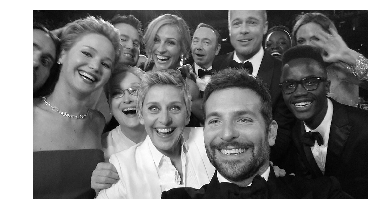

In [4]:
group_img = cv2.imread(group, 0)
plot_images([group_img])

In [5]:
# Detect all faces in group picture
face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))
box = face_cascade.detectMultiScale(group_img, 1.01, 10)

# Draw a box around each detected face
group_copy = group_img.copy()
# 5, 9, 10
for (x, y, w, h) in [box[5], box[9], box[10]]:
    cv2.rectangle(group_copy, (x, y), (x+w, y+h), (255, 255, 255), 5)

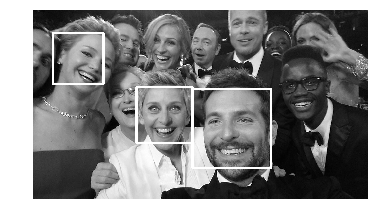

In [6]:
plot_images([group_copy])

In [7]:
def get_train_data(path, title = "Subject"):
    imgs = []
    for file in sorted(os.listdir(path)):
        if "_" in file and "_S" not in file and "t_" not in file:
            imgs.append((cv2.imread(path + file, 0), title + " - " + file[-6:-4]))
        
    return imgs

def get_faces(data, size, ss = 1.1):
    faces = []
    for img, title in tqdm(data):
        f = face_cascade.detectMultiScale(img, ss, 15)
        if len(f):
            x, y, w, h = f[0]
            img = img[y:y+h, x:x+w]
        img = cv2.resize(img, size).reshape(size)
        faces.append((img, title))
        
    return faces

In [8]:
data_0 = get_train_data(path_to_data + path_to_people[0], "Bradley")
data_1 = get_train_data(path_to_data + path_to_people[1], "Ellen")
data_2 = get_train_data(path_to_data + path_to_people[2], "Jennifer")

In [9]:
s = 128

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

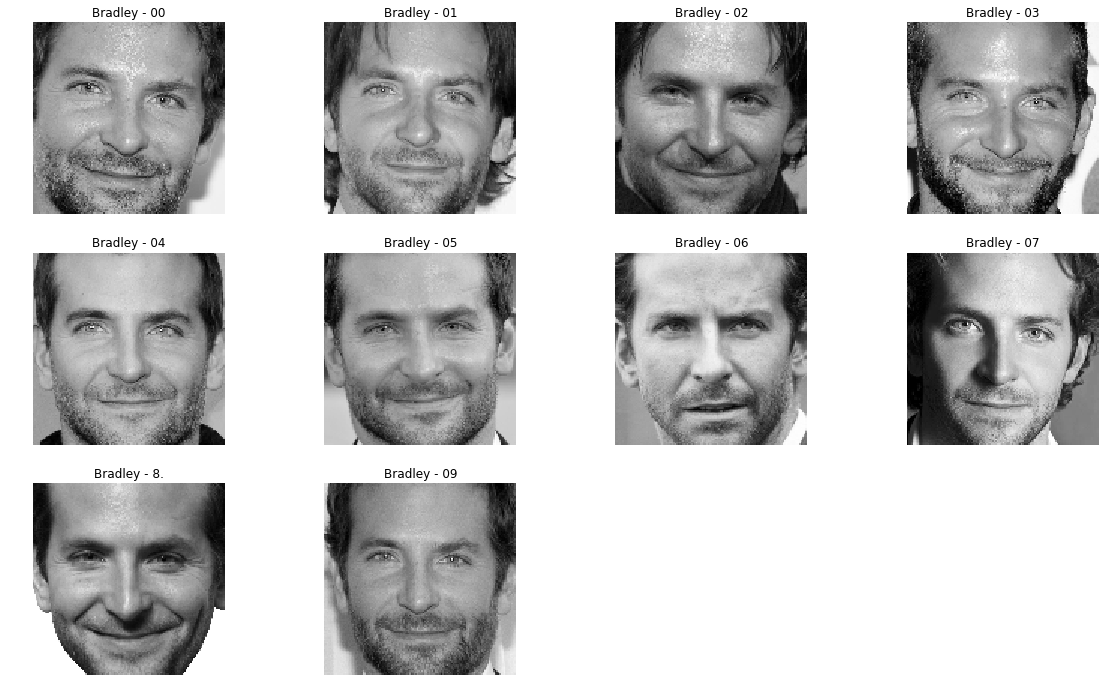

In [10]:
faces_0 = get_faces(data_0, (s, s), ss = 1.05)
plot_images(faces_0)

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

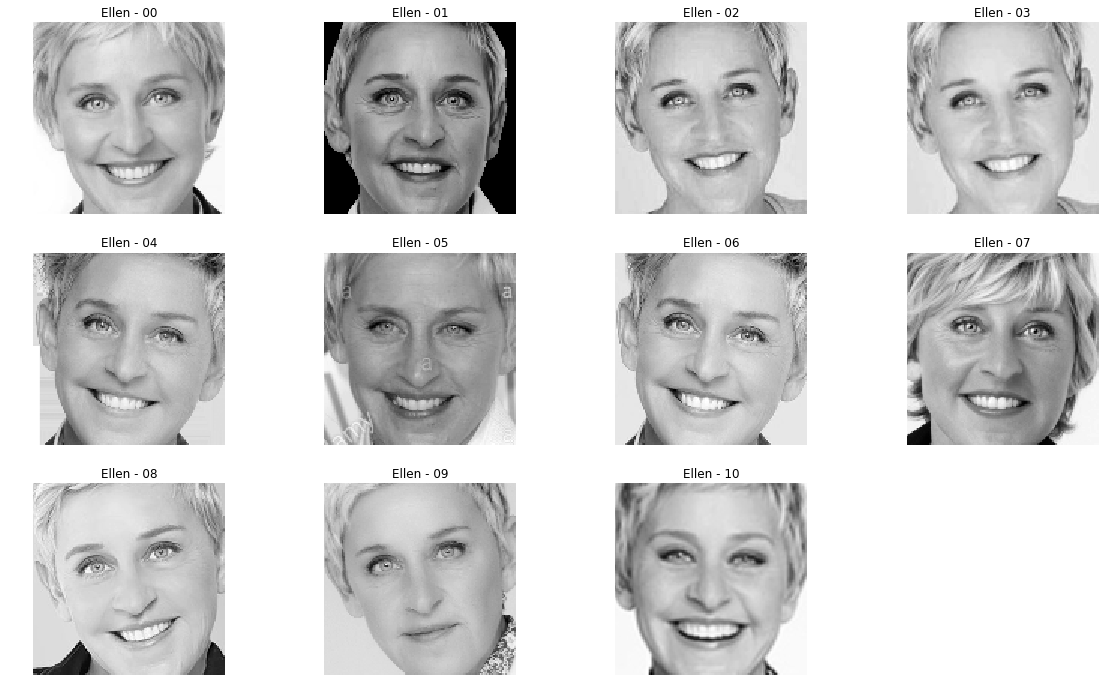

In [11]:
faces_1 = get_faces(data_1, (s, s), ss = 1.05)
plot_images(faces_1)

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

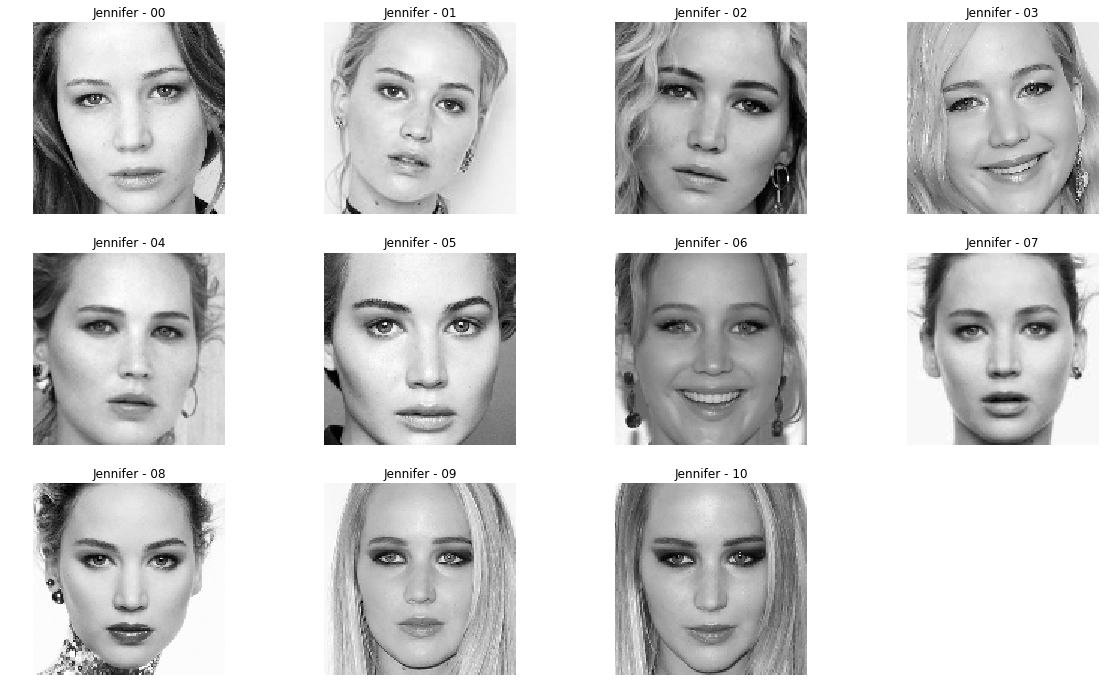

In [12]:
faces_2 = get_faces(data_2, (s, s), ss = 1.05)
plot_images(faces_2)

## Description of dataset
My goal when choosing the data was to have diffent neutral backgroud, different facial expressions and angles. After running the cropping method I realized that some faces were not good. For instance, a photo on a profile would not work, so I updated the dataset untill is was robust. My images all had only one face in them to ensure the validity of the face detection algorithm.

# 2. Eigenvector Representation

In [13]:
# Prepare the data
f_0, y_0 = np.array(faces_0)[:,0], np.array(["Bradley" for _ in faces_0])
f_1, y_1 = np.array(faces_1)[:,0], np.array(["Ellen" for _ in faces_1])
f_2, y_2 = np.array(faces_2)[:,0], np.array(["Jennifer" for _ in faces_2])
f_0 = np.array([np.array(x) for x in f_0])
f_1 = np.array([np.array(x) for x in f_1])
f_2 = np.array([np.array(x) for x in f_2])

X_tr = np.concatenate([f_0, f_1, f_2])
X_tr = X_tr.reshape(X_tr.shape[0], -1)
y_tr = np.hstack((y_0, y_1, y_2))

(32, 32)
[  4.20442363e-01   9.03347874e-02   7.12978862e-02   5.79196233e-02
   4.40479695e-02   3.49826460e-02   2.97788083e-02   2.39962378e-02
   2.10024244e-02   1.93427202e-02   1.81408694e-02   1.67691997e-02
   1.55494105e-02   1.50910570e-02   1.22657736e-02   1.11013600e-02
   1.03087902e-02   1.00743648e-02   9.45503411e-03   9.05106375e-03
   8.23003812e-03   7.99512706e-03   6.66109880e-03   6.53236557e-03
   6.01987901e-03   5.76222062e-03   5.02374936e-03   4.88437507e-03
   4.12796797e-03   2.31881311e-03   1.49197613e-03   2.01674413e-31]


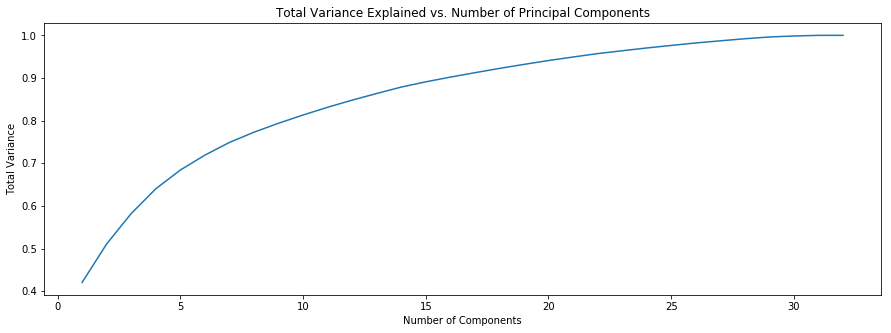

In [14]:
# Get PCA and fit data
pca = PCA()
x_pca = pca.fit_transform(X_tr)
l = pca.explained_variance_ratio_.size

print(x_pca.shape)
print(pca.explained_variance_ratio_)

# Plot the cumulative summation of the explained variance
plt.figure(figsize=(15, 5))
plt.plot(range(1, l+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components'), plt.ylabel('Total Variance')
plt.title('Total Variance Explained vs. Number of Principal Components')
plt.show()

## Number of vectors required
As we can see from the graph above, the variance becomes smaller and smaller as the number of components increase. The required number of components for maximum results is obviously all of them, but since the total variance seems to reach a plateau at around 30 components, it should be fine.

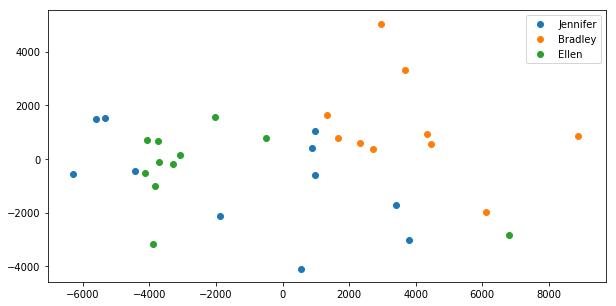

In [15]:
# eigenspace
people = set(y_tr)
plt.figure(figsize=(10, 5))
for p in people:
    xs = x_pca[y_tr == p, :]
    plt.scatter(xs[:,0], xs[:,1])
    plt.legend(people)

plt.show()

## KNN
### k = 1

In [16]:
# original pixel
model_orig = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model_orig.fit(X_tr, y_tr)
pred = model_orig.predict(X_tr)
print("Pixel space accuracy:", accuracy_score(y_tr, pred))


# eigenspace
model_eig = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model_eig.fit(x_pca, y_tr)
pred = model_eig.predict(x_pca)
print("Eigenspace accuracy:", accuracy_score(y_tr, pred))

Pixel space accuracy: 1.0
Eigenspace accuracy: 1.0


### k = 3

In [17]:
# original pixel
model_orig = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_orig.fit(X_tr, y_tr)
pred = model_orig.predict(X_tr)
print("Pixel space accuracy:", accuracy_score(y_tr, pred))


# eigenspace
model_eig = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_eig.fit(x_pca, y_tr)
pred = model_eig.predict(x_pca)
print("Eigenspace accuracy:", accuracy_score(y_tr, pred))

Pixel space accuracy: 0.875
Eigenspace accuracy: 0.875


The KNN analysis proves that the clusters are good. With one neighbour, the accuracy of the classification is 100%. On the otherhand, we observe that when comparing with more neighbours, the accuracy deacreses. This means that the model was able to cluster properly, but that the clusters are not tight.

Comparing the pixel space knn accuracy and the eigenspace accuracy, we notice that the are the same. We should expect them to corrolate, but that does not mean that they should have the same values.

# 3. Face Detection & Identification